In [1]:
from config.database import FORECAST_DB_NAME, PRODUCTION_COLLECTION_NAME, WEATHER_COLLECTION_NAME
from data_handling.transform import PARAMETERS_NAME_MAP
from database.main import mongo_handler
import pandas as pd

# object_a_query = {"object_name": "A"}
object_b_query = {"object_name": "A"}
object_c_query = {"object_name": "B"}

query_list = [object_b_query, object_c_query]
historical_data_list = []
weather_data_list = []

for query in query_list:

    historical_data_df = mongo_handler.retrieve_production_data(
        FORECAST_DB_NAME, PRODUCTION_COLLECTION_NAME, query)
    historical_data_list.append(historical_data_df)
    weather_data_df = mongo_handler.retrieve_weather_data(
        FORECAST_DB_NAME, WEATHER_COLLECTION_NAME, query)
    
    historical_data_df['start_time'] = pd.to_datetime(
    historical_data_df['start_time']) 
    weather_data_df['start_time'] = pd.to_datetime(
            weather_data_df['start_time'])
    merged_data_df = pd.merge(historical_data_df, weather_data_df, on="start_time", how="inner")
    weather_data_list.append(merged_data_df)
    


In [2]:
from plotly.offline import iplot
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from pandas import DataFrame


def normalize(entry: float, feature_range=(0, 1)):
    min_value, max_value = min(entry), max(entry)
    return [(x - min_value) / (max_value - min_value) * (feature_range[1] - feature_range[0]) + feature_range[0] for x in entry]

def handle_object_vizualization(historical_data: DataFrame, object_name: str):
    x_values = historical_data["start_time"].tolist()
    y_values = historical_data['value'].tolist()

    if len(x_values) == 0 or len(y_values) == 0:
        print("Error: No valid data found for visualization.")
        return

    print("Max production value for park {}: {} KWh".format(object_name, max(y_values)))
    print("Data is available starting from: {}  {}".format(min(x_values), max(x_values)))

    scatter_traces = [
        go.Scatter(
            x=x_values,
            y=y_values,
            name='Vērtība',
        )
    ]

    fig = go.Figure(data=scatter_traces)

    layout = dict(
        xaxis=dict(title='Datums'),
        yaxis=dict(title='Vērtība')
    )

    fig.update_layout(layout, width=1300, height=600)
    iplot(fig)

for historical_data, object_name in zip(historical_data_list, [ 'B', 'C']):
    handle_object_vizualization(historical_data, object_name)

Max production value for park B: 1890 KWh
Data is available starting from: 2023-08-30 21:00:00  2024-04-14 22:00:00


Max production value for park C: 227.336 KWh
Data is available starting from: 2023-06-06 21:00:00  2024-04-14 22:00:00


In [6]:
from pandas import DataFrame

interesting_parameters = [{"name":"Temperatūra", "db_name": "temperature", "unit": "pēc Celsija"}, 
                          {"name": "Relatīvais mitrums", "db_name": "relative_humidity", "unit": "%"}, 
                          {"name": "Vēja ātrums",  "db_name": "wind_speed", "unit": "km/h"}, 
                          {"name": "Atmosfēras spiediens", "db_name": "pressure", "unit": "%"}, 
                          {"name": "Lietus", "db_name": "rain", "unit": "mm"},
                          {"name": "Tiešais starojums",  "db_name": "direct_radiation", "unit": "W/m²"},
                          {"name": "Difūzā atstarošanās", "db_name": "diffuse_radiation", "unit": "W/m²"},]

def handle_weather_data_vizualization(historical_data: DataFrame, object_name: str, parameter: dict[str, str]):
    
    x_values = historical_data["start_time"].tolist()
    y_values = historical_data[parameter.get("db_name")].tolist()


    if len(x_values) == 0 or len(y_values) == 0:
        print("Error: No valid data found for visualization.")
        return

    print("Maksimālā {} vērtība {} parkam: {} ".format(parameter.get("name"), object_name, max(y_values)))
    print("Dati ir pieejami, sākot no: {} līdz {}".format(min(x_values), max(x_values)))

    scatter_traces = [
        go.Scatter(
            x=x_values,
            y=y_values,
            name=parameter.get("name"),
        )
    ]

    fig = go.Figure(data=scatter_traces)

    layout = dict(
        # title='{} saules parka "{}" atrašanās vieta, {}'.format(parameter.get("name"), object_name, parameter.get("unit")),
        xaxis=dict(title='Datums'),
        yaxis=dict(title=parameter.get("name"))
    )

    fig.update_layout(layout, width=1300, height=600)
    iplot(fig)

for weather_data, object_name in zip(weather_data_list, ['B', 'C']):
    for parameter in interesting_parameters:
        handle_weather_data_vizualization(weather_data, object_name, parameter)

Maksimālā Temperatūra vērtība B parkam: 24.4 
Dati ir pieejami, sākot no: 2023-08-30 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Relatīvais mitrums vērtība B parkam: 100 
Dati ir pieejami, sākot no: 2023-08-30 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Vēja ātrums vērtība B parkam: 41.1 
Dati ir pieejami, sākot no: 2023-08-30 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Atmosfēras spiediens vērtība B parkam: 1029.2 
Dati ir pieejami, sākot no: 2023-08-30 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Lietus vērtība B parkam: 11.3 
Dati ir pieejami, sākot no: 2023-08-30 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Tiešais starojums vērtība B parkam: 612.0 
Dati ir pieejami, sākot no: 2023-08-30 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Difūzā atstarošanās vērtība B parkam: 339.0 
Dati ir pieejami, sākot no: 2023-08-30 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Temperatūra vērtība C parkam: 29.7 
Dati ir pieejami, sākot no: 2023-06-06 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Relatīvais mitrums vērtība C parkam: 100 
Dati ir pieejami, sākot no: 2023-06-06 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Vēja ātrums vērtība C parkam: 39.0 
Dati ir pieejami, sākot no: 2023-06-06 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Atmosfēras spiediens vērtība C parkam: 1029.2 
Dati ir pieejami, sākot no: 2023-06-06 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Lietus vērtība C parkam: 7.7 
Dati ir pieejami, sākot no: 2023-06-06 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Tiešais starojums vērtība C parkam: 766.0 
Dati ir pieejami, sākot no: 2023-06-06 21:00:00 līdz 2024-04-28 23:00:00


Maksimālā Difūzā atstarošanās vērtība C parkam: 374.0 
Dati ir pieejami, sākot no: 2023-06-06 21:00:00 līdz 2024-04-28 23:00:00


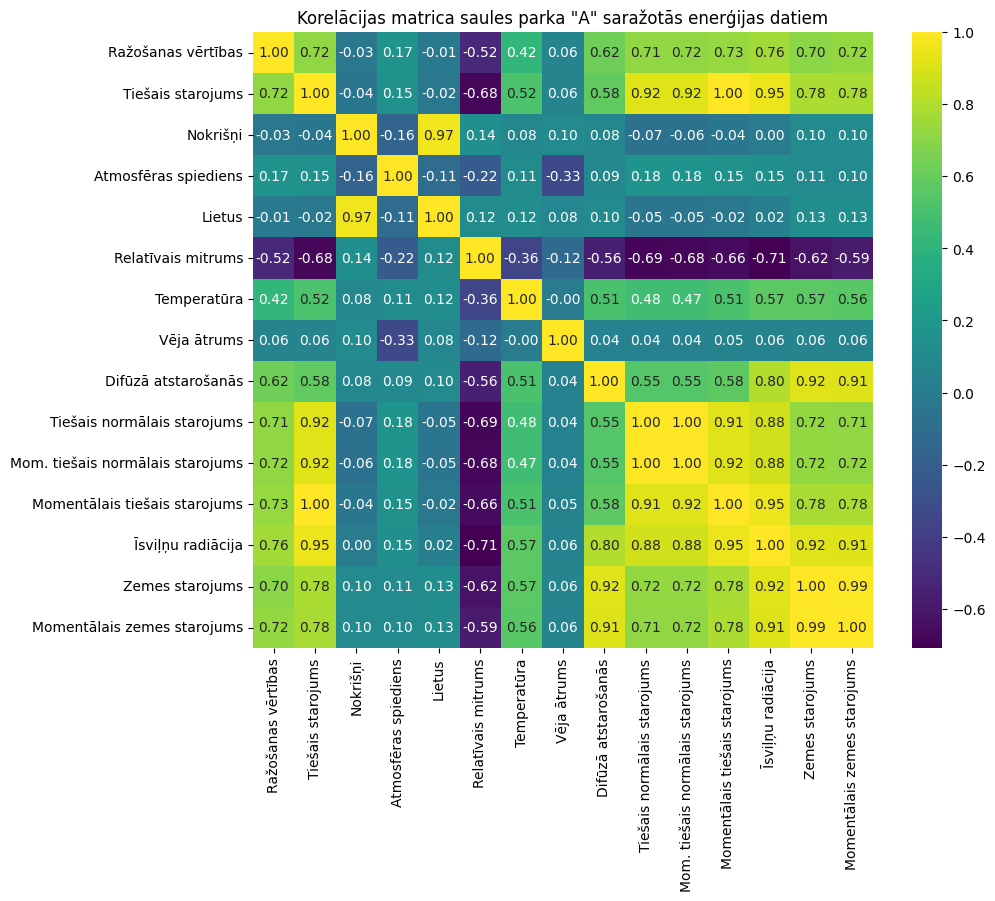

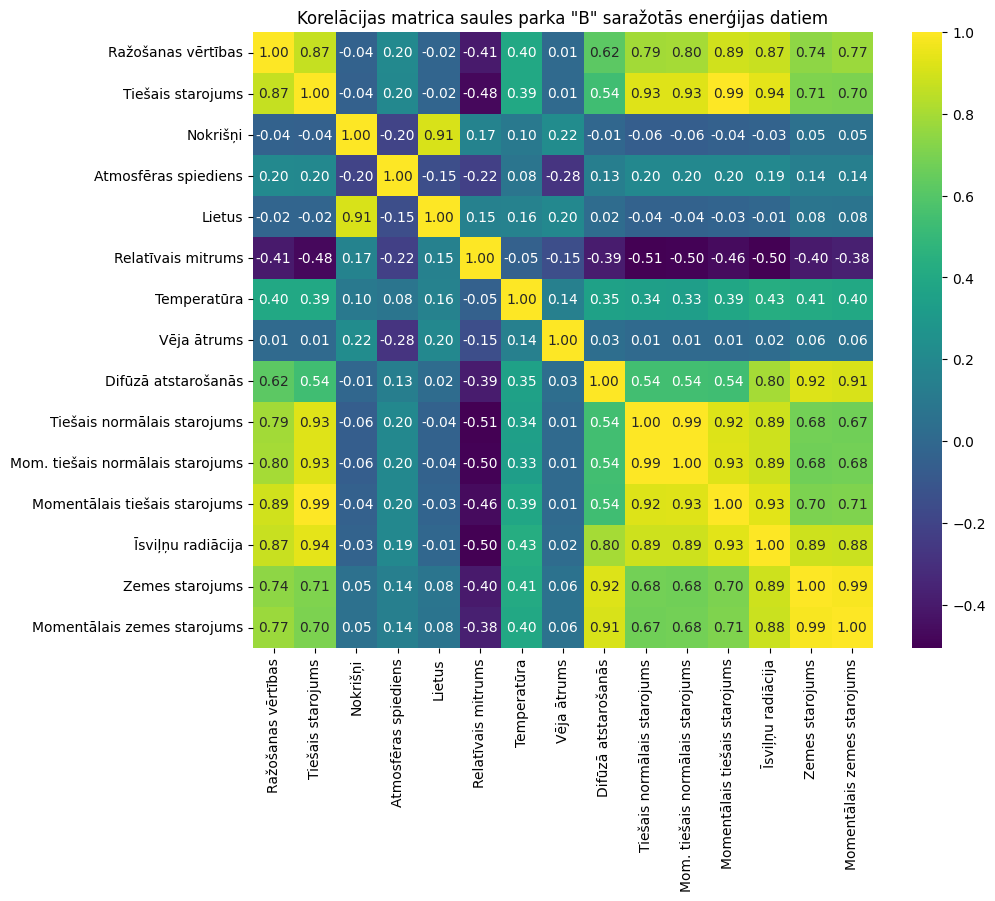

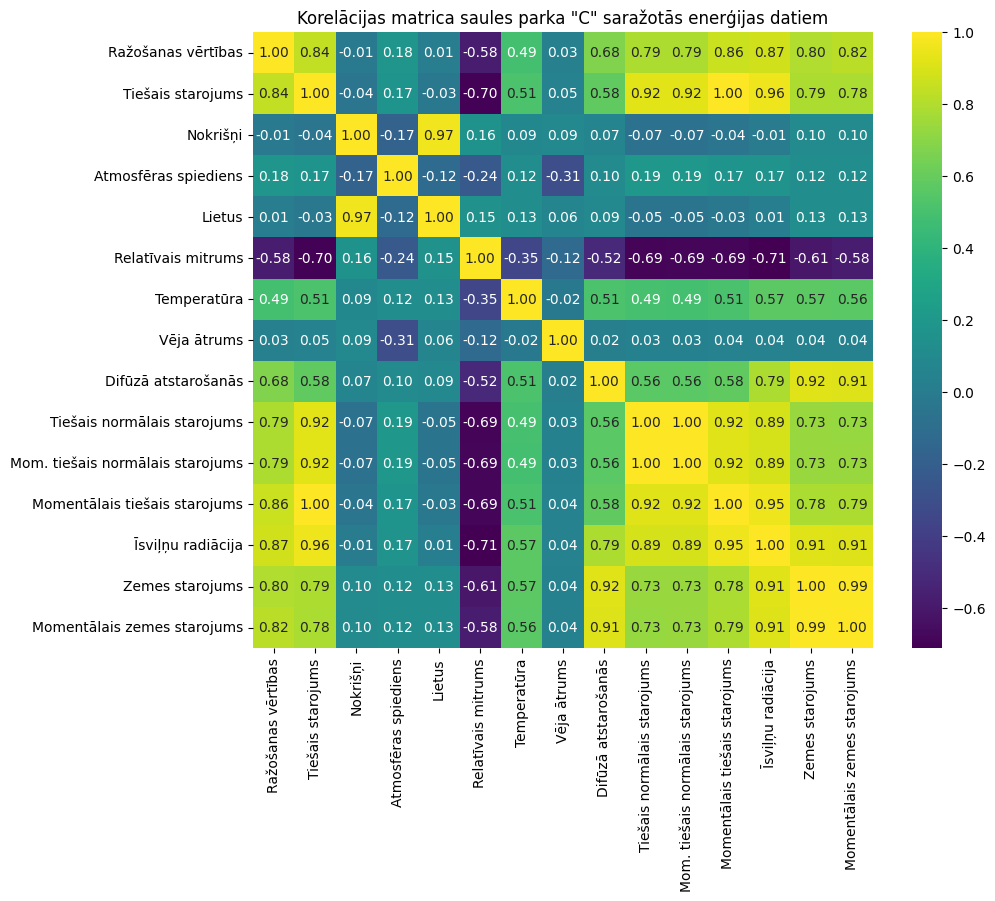

In [3]:
for historical_data, object_name in zip(weather_data_list, ['A', 'B', 'C']):
    numeric_df = historical_data.select_dtypes(include=['float64', 'int64'])
    numeric_df = numeric_df.rename(columns=PARAMETERS_NAME_MAP)
    correlation_matrix = numeric_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
    plt.title('Korelācijas matrica saules parka "{}" saražotās enerģijas datiem'.format(object_name))
    plt.show()